In [1]:
'''
个人实验时，在后续调研模型的时候出现cuDNN初始化失败的情况
查阅资料后通过以下代码解决，但是每台机器的环境都不同，
可以先无视下段代码，如果出现类似情况，再使用，尝试解决。
'''
import os # 设置调用的gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '/gpu:0'
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
# 设置gpu使用的显存占最大显存的比例，在跑小模型的时候是有用的
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                  # weights='imagenet'可以从网上下载在ImageNet训练后产生的权重
                  # 因为版本更新原因，可能会报错，所以我们本地文件加载权重的方法
                  include_top=False, # 指定模型是否包含最后的全连接网络
                  input_shape=(150, 150, 3) # 输入到网络中的图像张量形状
                  ) 


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [4]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'cats_and_dogs_small/train'
val_dir = 'cats_and_dogs_small/validation' # 三个集的路径
test_dir = 'cats_and_dogs_small/test'

datagen = ImageDataGenerator(rescale=1./255) # 归一化
batch_size = 5

def extract_features(dir, sample_count):
    # 通过ImageDataGenerator迭代生成数据，送入conv_base进行转换
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
# 将训练集、验证集、测试集的数据都通过conv_base进行转换，得到对应的特征和标签
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(val_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)
# 将得到的特征展平，即全连接层需要的形状
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5)) # 注意要使用 dropout 正则化
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6085 - acc: 0.6570 - val_loss: 0.4416 - val_acc: 0.8120

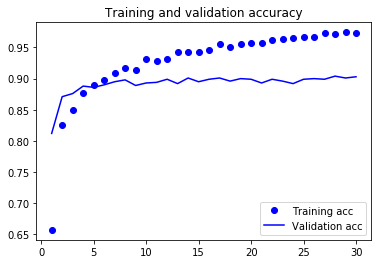

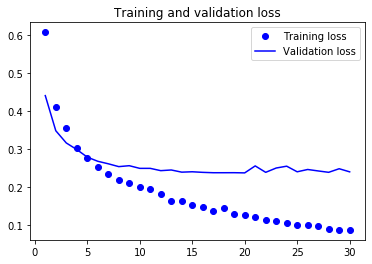

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [2]:
from keras import models, layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
conv_base.trainable = False

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False